## Pandas 2.0 

**Goal**: 

Provide a quick introduction to the main features on Pandas 2.0 release and discuss some background on the need for this upgrade. Comparison of old and new pandas APIs. 


Hopefully this will help build an intution on the need for Pandas 2.0

**Links**:
- [pandas 2.0 Release notes](https://pandas.pydata.org/docs/dev/whatsnew/v2.0.0.html)
- [pandas and the Arrow revolution - Marc Garcia](https://datapythonista.me/blog/pandas-20-and-the-arrow-revolution-part-i) 

### Pandas: 
- 2008, Wes McKinney
- Written in C, relies on numpy
- Single core processing 

Pandas has been the defacto dataframe library in python for a long time. The following features helped it gain this position:
- Robust I/O support: csv, json, parquet etc. - ability to read and write data from different formats
- Data allignment - gain automatic label-based alignment in computations and easily manipulate messy data into an orderly form
- Flexible groupby aggregation and data transformations  

### Limitations:
- Numpy is never built as a backend for dataframe libraries but Apache Arrow is. This limits the performance of Pandas and some examples are the poor support for strings, the lack of missing values. 
- Pandas is single threaded and is not able to completely utilize the full potential of multicore 
- Pandas is not able to scale to large datasets because of memory limitations


As we discussed ealier Pandas has been steadily making changes to suport these limitations. By introducing some new extension array types like category data type, nullable integer and float data types, and the string data type etc. 


### Pandas 2.0 Main Features ([full list](https://pandas.pydata.org/docs/dev/whatsnew/v2.0.0.html))
- PyArrow backed dataframes
- Index supports all numpy numeric dtypes, previously only int64, uint64 and float64 were supported
- dtype_backend option to control the dtype 
    - dtype_backend = 'arrow' if you want to use arrow backed dtypes
    - dtype_backend = 'numpy_nullable' backed by nullable dtypes


### Why Arrow?
Arrow is a cross-language development platform for in-memory columnar data format. It specifies a standardized language-independent columnar memory format for flat and hierarchical data, organized for efficient analytic operations on modern hardware. It also provides computational libraries and zero-copy streaming messaging and interprocess communication.

- Speed - in general Arrow operations are faster than numpy
- Memory efficiency - because of better data type support
- Missing values - no need to have pandas own version for each data type (e.g. Int64Dtype)
- Interoperability - easily handover data between different systems e.g. pandas to spark or pandas to polars

In [25]:
import pandas as pd
import numpy as np
import pyarrow as pa
import timeit, time

print('pandas', pd.__version__)
print('numpy', np.__version__)
print('pyarrow', pa.__version__)


pandas 2.0.1
numpy 1.24.3
pyarrow 12.0.0



### Load Data

Chicago crime records from the Chicago Police Department [Data Source](https://data.cityofchicago.org/Public-Safety/Crimes-2022/9hwr-2zxp)

Note - the default cell outputs you are seeing in this notebook are from using the full data file from Jan 2018 to 12 June 2023. 

In [4]:
file_path = "ChicagoCrimes2022.csv"  # Partial 2022 data 01 Jan to 22 August 2022
# file_path = "Crimes_-_2001_to_Present.csv" # Full data from Jan 2018 to 12 June 2023 

# read csv file in pandas - default
def read_csv_pandas_numpy(file_path):
    df = pd.read_csv(file_path)
    return df

df_with_numpy = read_csv_pandas_numpy(file_path)

# date range and num of rows
print(f"The date range in the file is from {df_with_numpy.Date.min()} to {df_with_numpy.Date.max()}")
print(f"The number of rows in the file is {df_with_numpy.shape[0]}")

df_with_numpy.head()

The date range in the file is from 01/01/2018 07:45:00 PM to 12/31/2022 12:59:00 PM
The number of rows in the file is 1293449


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,13097521,JG289787,06/05/2023 11:59:00 PM,065XX S PROMONTORY DR,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,PARK PROPERTY,True,False,...,-87.570448,"(41.776400433, -87.570448042)",32.0,22538.0,9.0,134.0,33.0,24.0,18.0,262.0
1,13097583,JG289776,06/05/2023 11:49:00 PM,033XX W MADISON ST,0320,ROBBERY,STRONG ARM - NO WEAPON,CHA PARKING LOT / GROUNDS,False,True,...,-87.709360,"(41.880933953, -87.709360298)",11.0,21572.0,28.0,39.0,23.0,30.0,16.0,86.0
2,13097506,JG289783,06/05/2023 11:48:00 PM,001XX N MAY ST,1330,CRIMINAL TRESPASS,TO LAND,HOTEL / MOTEL,True,False,...,-87.655573,"(41.883183998, -87.655572726)",41.0,14917.0,29.0,63.0,46.0,44.0,15.0,92.0
3,13097455,JG289793,06/05/2023 11:45:00 PM,009XX E 84TH ST,502P,OTHER OFFENSE,FALSE / STOLEN / ALTERED TRP,STREET,False,False,...,-87.601776,"(41.742168742, -87.601775672)",9.0,21546.0,40.0,141.0,35.0,61.0,20.0,241.0
4,13098302,JG290581,06/05/2023 11:45:00 PM,057XX S MAY ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,-87.653546,"(41.78982859, -87.653546459)",19.0,21559.0,66.0,409.0,2.0,11.0,17.0,261.0


In [5]:
# read csv file in pandas - arrow
def read_csv_pandas_arrow(file_path):
    df = pd.read_csv(file_path, engine='pyarrow', dtype_backend='pyarrow')
    return df

df_with_arrow = read_csv_pandas_arrow(file_path)

In [6]:
%%timeit
read_csv_pandas_numpy(file_path)

7.25 s ± 273 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
read_csv_pandas_arrow(file_path)

750 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
df_with_numpy.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293449 entries, 0 to 1293448
Data columns (total 30 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1293449 non-null  int64  
 1   Case Number                 1293449 non-null  object 
 2   Date                        1293449 non-null  object 
 3   Block                       1293449 non-null  object 
 4   IUCR                        1293449 non-null  object 
 5   Primary Type                1293449 non-null  object 
 6   Description                 1293449 non-null  object 
 7   Location Description        1287673 non-null  object 
 8   Arrest                      1293449 non-null  bool   
 9   Domestic                    1293449 non-null  bool   
 10  Beat                        1293449 non-null  int64  
 11  District                    1293449 non-null  int64  
 12  Ward                        1293399 non-null  float64
 1

In [9]:
# Get the size of the csv file
import os 
f"csv file size: {round(os.stat(file_path).st_size/(1024*1024), 2)} MB"

'csv file size: 327.91 MB'

In [10]:
df_with_arrow.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293449 entries, 0 to 1293448
Data columns (total 30 columns):
 #   Column                      Non-Null Count    Dtype          
---  ------                      --------------    -----          
 0   ID                          1293449 non-null  int64[pyarrow] 
 1   Case Number                 1293449 non-null  string[pyarrow]
 2   Date                        1293449 non-null  string[pyarrow]
 3   Block                       1293449 non-null  string[pyarrow]
 4   IUCR                        1293449 non-null  string[pyarrow]
 5   Primary Type                1293449 non-null  string[pyarrow]
 6   Description                 1293449 non-null  string[pyarrow]
 7   Location Description        1293449 non-null  string[pyarrow]
 8   Arrest                      1293449 non-null  bool[pyarrow]  
 9   Domestic                    1293449 non-null  bool[pyarrow]  
 10  Beat                        1293449 non-null  int64[pyarrow] 
 11  District   

In [11]:
%%timeit
df_with_numpy['Primary Type'].value_counts()

108 ms ± 3.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
df_with_arrow['Primary Type'].value_counts()

64.3 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Data Types
Arrow has better support for data types than numpy. Below i compare the bool and datetime data types between numpy and arrow.

In [13]:
df_with_numpy['Arrest'].memory_usage(deep=True, index=False)

1293449

In [14]:
df_with_arrow['Arrest'].memory_usage(deep=True, index=False)

161827

Numpy uses 8 bits to store a bool value while arrow uses only one bit

In [15]:
df_with_numpy['Date'].head()

0    06/05/2023 11:59:00 PM
1    06/05/2023 11:49:00 PM
2    06/05/2023 11:48:00 PM
3    06/05/2023 11:45:00 PM
4    06/05/2023 11:45:00 PM
Name: Date, dtype: object

In [37]:
# convert the date to pandas date 
df_with_numpy['Date'] = df_with_numpy['Date'].astype('datetime64[ns]')
df_with_numpy['Date'].memory_usage(deep=True, index=False)

10347592

In [17]:
# change the date type from string to 'timestamp[pyarrow]'
df_with_arrow['Date'] = df_with_arrow['Date'].astype('datetime64[ns]').astype(pd.ArrowDtype(pa.timestamp("s")))
df_with_arrow['Date'].memory_usage(deep=True, index=False)

10347592

Note: I converted the date column into pyarrow timestamp type after converting it to a pandas datetime type first. Because i had some issue with using arrow timestamp format directly.

#### Data type conversions
pandas also introduced a new ExtensionDtype for PyArrow data types. 
You can use this or use the string constructors as well e.g. `int64[pyarrow]` 

Below is a screenshot shows the equivalent numpy, pandas extension and pyarrow-backed data types [source](https://pandas.pydata.org/docs/dev/reference/arrays.html#pyarrow)


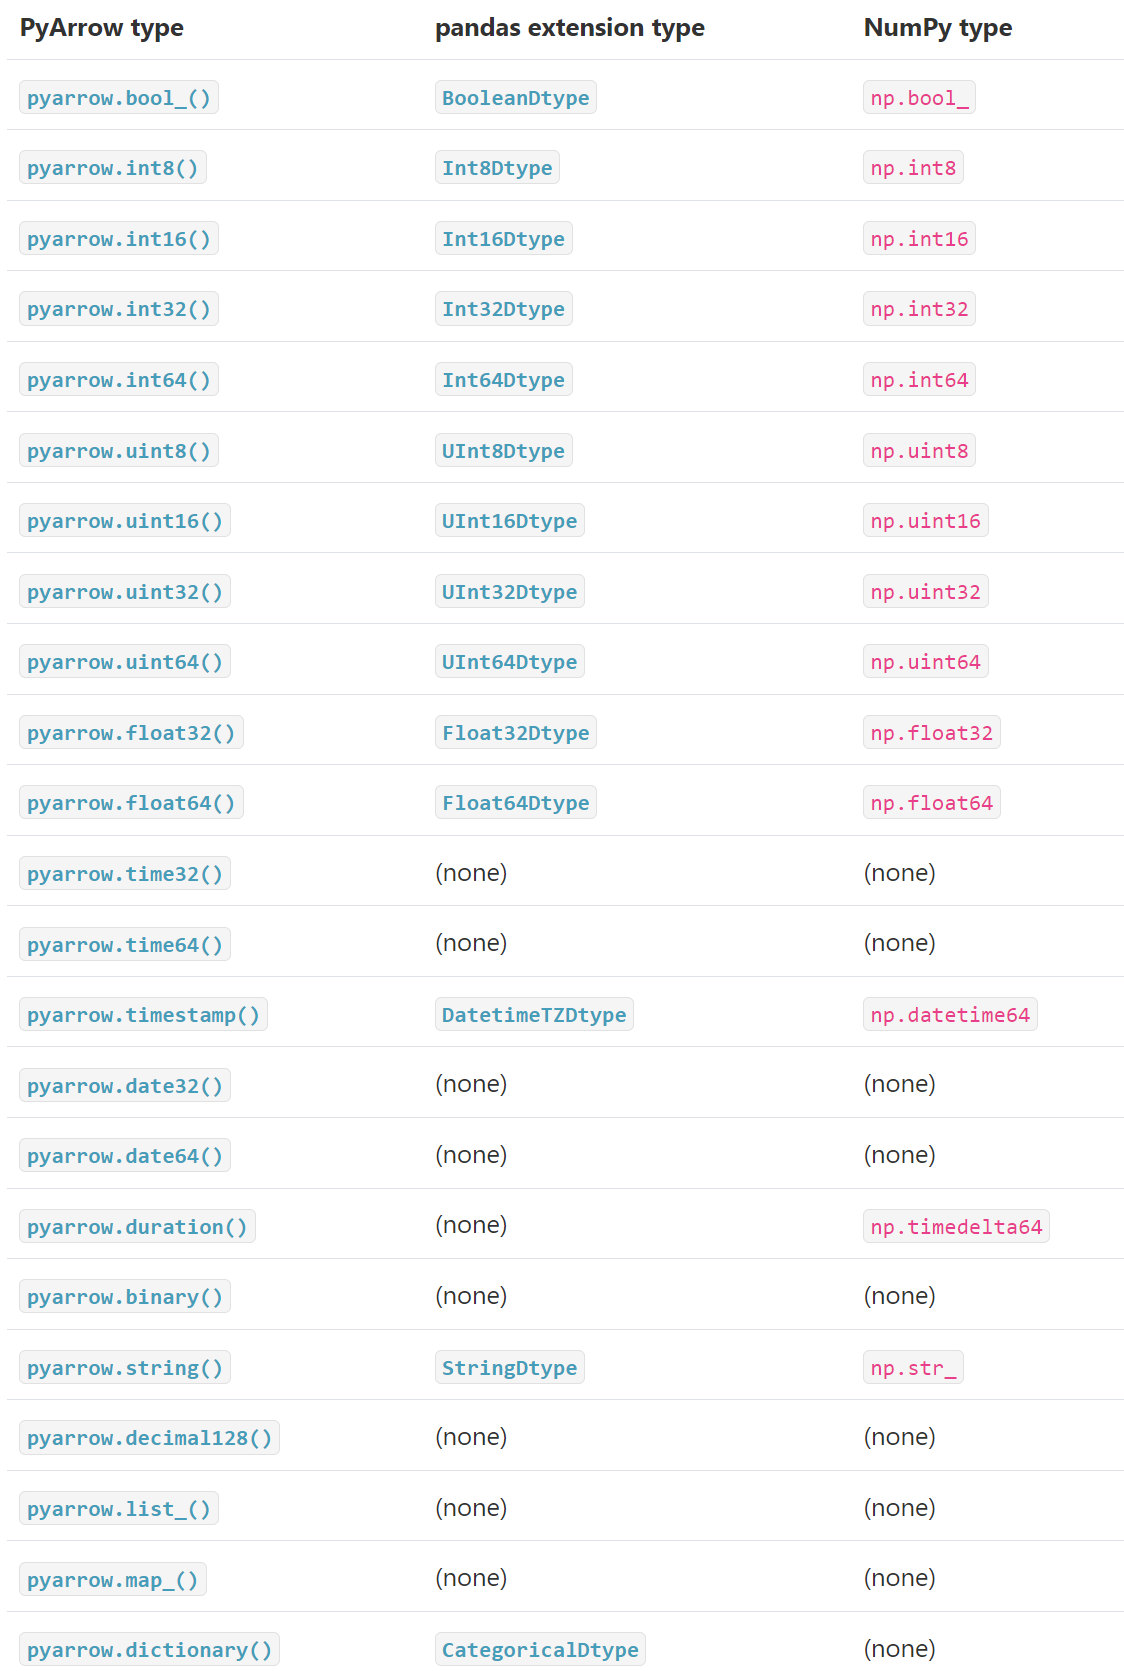

In [18]:
pd.ArrowDtype(pa.int64())

int64[pyarrow]

#### Create a Date only column
The date column has both date and time information. We will create a new column with only date information and compare the performance of numpy and arrow backed pandas dataframes.

In [19]:
df_with_numpy['Date'].head()

0   2023-06-05 23:59:00
1   2023-06-05 23:49:00
2   2023-06-05 23:48:00
3   2023-06-05 23:45:00
4   2023-06-05 23:45:00
Name: Date, dtype: datetime64[ns]

In [20]:
df_with_numpy['Date Only'] = df_with_numpy['Date'].dt.date
print(f"Memory usage : {df_with_numpy['Date Only'].memory_usage(deep=True, index=False)} bytes")
df_with_numpy['Date Only'].head()

Memory usage : 51737960 bytes


0    2023-06-05
1    2023-06-05
2    2023-06-05
3    2023-06-05
4    2023-06-05
Name: Date Only, dtype: object

In [21]:
df_with_arrow['Date Only'] = df_with_arrow['Date'].astype(pd.ArrowDtype(pa.date32()))
print(f"Memory usage: {df_with_arrow['Date Only'].memory_usage(deep=True, index=False)} bytes")

df_with_arrow['Date Only'].head()

Memory usage: 5335478 bytes


0   2023-06-05
1   2023-06-05
2   2023-06-05
3   2023-06-05
4   2023-06-05
Name: Date Only, dtype: date32[day][pyarrow]

Performance Comparison with Old vs New Pandas

In [33]:
# convert number to seconds or milliseconds 
def convert_to_seconds(number, loop=1000):
    """ given a number output should be a string with the number of seconds or milliseconds
    """
    n = number/loop
    # if n < 0.001:
    #     return f"{round(n*1000000, 2)} us"
    # elif n < 0.1:
    #     return f"{round(n*1000, 2)} ms"
    # else:
    #     return f"{round(n, 2)} s"   
    return n
    
# get the value counts of the primary type
def get_value_counts(df):
    return df['Primary Type'].value_counts()

# get the sum of arrests
def get_sum_arrests(df):
    return df['Arrest'].sum()

# get mean latitude
def get_mean_latitude(df):
    return df['Latitude'].mean()

# block ends with ST
def block_ends_with_ST(df):
    return df[df['Block'].str.endswith('ST')]

# block contains VAN BUREN
def block_contains(df, text='VAN BUREN'):
    return df[df['Block'].str.contains(text)]

# get the daily mean numer of cases
def get_daily_mean_cases(df):
    return df.groupby('Date Only')['Case Number'].nunique().mean()


# number of loops to run the function
num_loops = 1000

speed_results = {}
candidates = ['pandas-numpy', 'pandas-arrow']

# for each candidate get the time taken to run the function and store it in a dictionary
for candidate in candidates:
    speed_results[candidate] = {}
    
    if candidate == 'pandas-numpy':
        speed_results[candidate]['read_csv'] = timeit.timeit(lambda: read_csv_pandas_numpy(file_path), number=1)
        df = read_csv_pandas_numpy(file_path)
        
    elif candidate == 'pandas-arrow':
        speed_results[candidate]['read_csv'] = timeit.timeit(lambda: read_csv_pandas_arrow(file_path), number=1)
        df = read_csv_pandas_arrow(file_path)
        
    speed_results[candidate]['get_value_counts'] = convert_to_seconds(timeit.timeit(lambda: get_value_counts(df), number=num_loops))
    speed_results[candidate]['get_sum_arrests'] = convert_to_seconds(timeit.timeit(lambda: get_sum_arrests(df), number=num_loops))
    speed_results[candidate]['get_mean_latitude'] = convert_to_seconds(timeit.timeit(lambda: get_mean_latitude(df), number=num_loops))
    speed_results[candidate]['block_ends_with_ST'] = convert_to_seconds(timeit.timeit(lambda: block_ends_with_ST(df), number=num_loops))
    speed_results[candidate]['block_contains'] = convert_to_seconds(timeit.timeit(lambda: block_contains(df), number=num_loops))


In [34]:
result = (pd
         .DataFrame(speed_results)
         .assign(multiple=(lambda x: round(x['pandas-numpy']/x['pandas-arrow'], 1)))
         )

result

,pandas-numpy,pandas-arrow,multiple
read_csv,7.533538,0.918611,8.2
get_value_counts,0.112616,0.064666,1.7
get_sum_arrests,0.001911,0.000229,8.3
get_mean_latitude,0.014820,0.003720,4.0
block_ends_with_ST,0.831451,0.404170,2.1
block_contains,0.785433,0.387702,2.0
